In [395]:
import torch
import pyro
import matplotlib.pyplot as plt
import util

device = "cuda" if torch.cuda.is_available() else "cpu"

# Generative model with true primitives

## Primitives 

In [294]:
class Square:
    def __init__(self, name, color, size):
        self.name = name
        self.color = color
        self.size = size
    
    def __repr__(self):
        return f"{self.name}(color={self.color.tolist()}, size={self.size.item():.1f})"

In [295]:
# primitives = [
#     Square("A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.1, device=device)),
#     Square("B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.2, device=device)),
#     Square("C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.3, device=device))
# ]
# num_primitives = len(primitives)

## Sample the stacking program

In [4]:
def sample_stacking_program(num_primitives, device):
    # Init
    stacking_program = []
    num_sampled_primitives = 0

    # Sample first primitive
    primitive_id_logits = torch.ones((num_primitives,), device=device)
    primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                               pyro.distributions.Categorical(logits=primitive_id_logits))
    num_sampled_primitives += 1
    stacking_program.append([primitive_id])

    # Sample the rest
    end_program = False
    while not end_program:
        # Sample an action for the next primitive
        # Action 0:     put to the left of existing stack
        # Action 1:     put on existing stack 1
        # ...
        # Action N:     put on existing stack N
        # Action N + 1: put to the right of existing stack
        # Action N + 2: end program
        num_actions = len(stacking_program) + 3
        action_id_logits = torch.ones((num_actions,), device=device)
        action_id = pyro.sample(f"action_id_{num_sampled_primitives}",
                                pyro.distributions.Categorical(logits=action_id_logits))

        if action_id == len(stacking_program) + 2:
            # End program
            end_program = True
            break
        else:
            # Sample primitive
            primitive_id_logits = torch.ones((num_primitives,), device=device)
            primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                                       pyro.distributions.Categorical(logits=primitive_id_logits))
            num_sampled_primitives += 1

            # Add to the stacking program based on previous action
            if action_id == 0:
                stacking_program.insert(0, [primitive_id])
            elif action_id == len(stacking_program) + 1:
                stacking_program.append([primitive_id])
            else:
                stacking_program[action_id - 1].append(primitive_id)

    return stacking_program


def stacking_program_to_str(stacking_program, primitives):
    primitive_stacks = []
    for stack in stacking_program:
        primitive_stack = []
        for primitive_id in stack:
            primitive_stack.append(primitives[primitive_id].name)
        primitive_stacks.append(primitive_stack)
    return primitive_stacks

In [5]:
# stacking_program = sample_stacking_program(num_primitives, device)
# stacking_program

## Sample continuous locations

In [6]:
def sample_raw_locations(stacking_program):
    uniform_dist = pyro.distributions.Uniform(0, 1)
    raw_locations = []
    for stack_id, stack in enumerate(stacking_program):
        primitive_raw_locations = []
        for primitive_id, primitive in enumerate(stack):
            primitive_raw_locations.append(pyro.sample(f"stack_{stack_id}_primitive_{primitive_id}_raw_loc",
                                                       uniform_dist))
        raw_locations.append(primitive_raw_locations)
    return raw_locations

In [7]:
# raw_locations = sample_raw_locations(stacking_program)
# raw_locations

## Render stacks

### Convert from raw locations to actual locations

In [8]:
def convert_raw_locations(raw_locations, stacking_program, primitives):
    # Extract stack widths
    stack_widths = []
    for stack_id, stack in enumerate(stacking_program):
        bottom_primitive_id = stack[0]
        bottom_primitive = primitives[bottom_primitive_id]
        stack_widths.append(bottom_primitive.size)

    # Compute right limits
    right_limits = [1.0]
    for stack_width in reversed(stack_widths[1:]):
        right_limits.insert(0, right_limits[0] - stack_width)

    # Check whether limits are ok
    if stack_widths[0] > right_limits[0]:
        print("error")
    else:
        print("ok")

    # Compute bottom locations
    y = torch.tensor(-1., device=device)
    current_x = -1.0
    locations = []
    for stack_id, (stack, primitive_raw_locations, right_limit) in enumerate(
        zip(stacking_program, raw_locations, right_limits)
    ):
        # Bottom primitive
        bottom_primitive_id = stack[0]
        bottom_primitive = primitives[bottom_primitive_id]
        bottom_primitive_raw_location = primitive_raw_locations[0]

        min_x = current_x
        max_x = right_limit - bottom_primitive.size
        x = bottom_primitive_raw_location * (max_x - min_x) + min_x
        current_x = x + bottom_primitive.size
        locations.append([torch.stack([x, y])])


    # Compute the locations of the rest of the primitives
    for stack_id, (stack, primitive_raw_locations) in enumerate(zip(stacking_program, raw_locations)):
        for primitive_order, primitive_id in enumerate(stack):
            if primitive_order != 0:
                size_bottom = primitives[stack[primitive_order - 1]].size
                size = primitives[primitive_id].size
                primitive_raw_location = primitive_raw_locations[primitive_order]
                x_bottom, y_bottom = locations[stack_id][-1]
                y = y_bottom + size_bottom
                min_x = x_bottom
                max_x = x_bottom + size_bottom / 2
                x = primitive_raw_location * (max_x - min_x) + min_x
                locations[stack_id].append(torch.stack([x, y]))

    return locations

In [9]:
# locations = convert_raw_locations(raw_locations, stacking_program, primitives)

### Render primitives

In [10]:
def get_canvas_xy(num_rows, num_cols, device):
    """Create xy points on the canvas

    Args
        num_rows (int)
        num_cols (int)

    Returns
        canvas_x [num_rows, num_cols]
        canvas_y [num_rows, num_cols]
    """

    x_range = torch.linspace(-1, 1, steps=num_cols, device=device)
    y_range = torch.linspace(-1, 1, steps=num_rows, device=device).flip(dims=[0])
    # [num_cols, num_rows]
    canvas_x, canvas_y = torch.meshgrid(x_range, y_range)
    # [num_rows, num_cols]
    canvas_x, canvas_y = canvas_x.T, canvas_y.T

    return canvas_x, canvas_y


def render_square(square, location, canvas):
    """Draws a square on a canvas whose xy limits are [-1, 1].

    Args
        square
        location [2]
        canvas [num_channels, num_rows, num_cols]

    Returns
        new_canvas [num_channels, num_rows, num_cols]
    """
    # Extract
    # []
    min_x, min_y = location
    max_x = min_x + square.size
    max_y = min_y + square.size
    num_rows, num_cols = canvas.shape[-2:]
    device = location.device

    # Canvas xy
    # [num_rows, num_cols]
    canvas_x, canvas_y = get_canvas_xy(num_rows, num_cols, device)

    # Draw on canvas
    new_canvas = canvas.clone()
    for channel_id in range(num_channels):
        new_canvas[
            channel_id,
            (canvas_x >= min_x) & (canvas_x <= max_x) & (canvas_y >= min_y) & (canvas_y <= max_y)
        ] -= (1 - square.color[channel_id])
    new_canvas = new_canvas.clamp(0, 1)

    return new_canvas


def init_canvas(device, num_channels=3, num_rows=256, num_cols=256):
     return torch.ones((num_channels, num_rows, num_cols), device=device)


def render(primitives, stacking_program, raw_locations, num_channels=3, num_rows=256, num_cols=256):
    # Convert
    locations = convert_raw_locations(raw_locations, stacking_program, primitives)

    # Render
    canvas = init_canvas(device, num_channels, num_rows, num_cols)
    for stack_id, stack in enumerate(stacking_program):
        for primitive_order, primitive_id in enumerate(stack):
            primitive = primitives[primitive_id]
            location = locations[stack_id][primitive_order]
            canvas = render_square(primitive, location, canvas)

    return canvas

In [11]:
# num_channels, num_rows, num_cols = 3, 256, 256
# canvas = torch.ones((num_channels, num_rows, num_cols), device=device)

# for stack_id, stack in enumerate(stacking_program):
#     for primitive_order, primitive_id in enumerate(stack):
#         primitive = primitives[primitive_id]
#         location = locations[stack_id][primitive_order]
#         canvas = render_square(primitive, location, canvas)

# plt.imshow(canvas.cpu().permute(1, 2, 0))

## All in one

ok


[['C']]

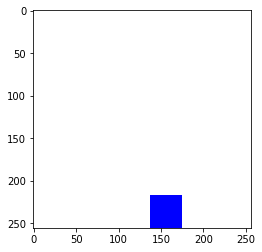

In [12]:
# Define params
primitives = [
    Square("A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.1, device=device)),
    Square("B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.2, device=device)),
    Square("C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.3, device=device))
]
num_primitives = len(primitives)
num_channels, num_rows, num_cols = 3, 256, 256

# Sample
stacking_program = sample_stacking_program(num_primitives, device)
raw_locations = sample_raw_locations(stacking_program)

# Render
img = render(primitives, stacking_program, raw_locations)

# Plot
plt.imshow(img.cpu().permute(1, 2, 0))
stacking_program_to_str(stacking_program, primitives)

# Learneable square

In [13]:
import torch.nn as nn

In [198]:
class LearnableSquare(nn.Module):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.raw_color = nn.Parameter(torch.randn((3,)))
        self.raw_size = nn.Parameter(torch.randn(()))
    
    @property
    def device(self):
        return self.raw_size.device

    @property
    def size(self):
        min_size = 0.01
        max_size = 1.0
        return self.raw_size.sigmoid() * (max_size - min_size) + min_size
    
    @property
    def color(self):
        return self.raw_color.sigmoid()
    
    def __repr__(self):
        return f"{self.name}(color={self.color.tolist()}, size={self.size.item():.1f})"

## Make an actual square we want to fit

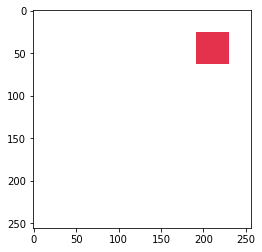

In [199]:
true_square = Square("A", torch.tensor([0.9, 0.2, 0.3], device=device), torch.tensor(0.3, device=device))
true_location = torch.tensor([0.5, 0.5], device=device)
img = render_square(true_square, true_location, init_canvas(device))
plt.imshow(img.cpu().permute(1, 2, 0))

## Soft rasterizer

In [266]:
import torch.nn.functional as F


def get_min_edge_distance(square, location, point):
    """Computes shortest distance from a point to the square edge.
    Negative if it's inside the square.
    Positive if it's outside the square.
    
    Args
        square
        location [2]
        point [*shape, 2]
    
    Returns [*shape]
    """
    # Extract
    device = location.device
    # []
    min_x, min_y = location
    max_x = min_x + square.size
    max_y = min_y + square.size
    shape = point.shape[:-1]
    # [*shape]
    x, y = point[..., 0], point[..., 1]
    
    # Determine which area the point is in
    # [*shape]
    # --High level areas
    up = (y >= max_y)
    middle = (y >= min_y) & (y < max_y)
    bottom = (y < min_y)
    left = (x < min_x)
    center = (x >= min_x) & (x < max_x)
    right = (x >= max_x)
    
    # --Use high level areas to define smaller sectors which we're going to work with
    area_1 = left & up
    area_2 = center & up
    area_3 = right & up
    area_4 = left & middle
    area_5 = center & middle
    area_6 = right & middle
    area_7 = left & bottom
    area_8 = center & bottom
    area_9 = right & bottom

    # Compute min distances
    # --Init the results
    # [*shape]
    min_edge_distance = torch.zeros_like(x)

    # --Compute distances for points in the corners (areas 1, 3, 7, 9)
    min_edge_distance[area_1] = torch.sqrt((x - min_x)**2 + (y - max_y)**2)[area_1]
    min_edge_distance[area_3] = torch.sqrt((x - max_x)**2 + (y - max_y)**2)[area_3]
    min_edge_distance[area_7] = torch.sqrt((x - min_x)**2 + (y - min_y)**2)[area_7]
    min_edge_distance[area_9] = torch.sqrt((x - max_x)**2 + (y - min_y)**2)[area_9]

    # --Compute distances for points in the outside strips (areas 2, 4, 6, 8)
    min_edge_distance[area_2] = (y - max_y)[area_2]
    min_edge_distance[area_4] = (min_x - x)[area_4]
    min_edge_distance[area_6] = (x - max_x)[area_6]
    min_edge_distance[area_8] = (min_y - y)[area_8]

    # --Compute distances for points inside the square
    min_edge_distance[area_5] = -torch.min(torch.stack([y - min_y, max_y - y, x - min_x, max_x - x]), dim=0)[0][area_5]
    
    return min_edge_distance


def get_render_log_prob(min_edge_distance, blur=1e-4):
    """
    Returns the (log) probability map used for soft rasterization as specified by
    equation (1) of
    https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Soft_Rasterizer_A_Differentiable_Renderer_for_Image-Based_3D_Reasoning_ICCV_2019_paper.pdf
    
    Also visualized here https://www.desmos.com/calculator/5z95dy2mny
    
    Args
        min_edge_distance [*shape]
        blur [] (default 1e-4): this is the σ in equation (1)
    
    Returns [*shape]
    """
    return F.logsigmoid(-torch.sign(min_edge_distance) * min_edge_distance**2 / blur)


def soft_render_square(square, location, background, background_depth=-1e-3, color_sharpness=1e-4, blur=1e-4):
    """Draws a square on a canvas whose xy limits are [-1, 1].
    
    Follows equations (2) and (3) in
    https://openaccess.thecvf.com/content_ICCV_2019/papers/Liu_Soft_Rasterizer_A_Differentiable_Renderer_for_Image-Based_3D_Reasoning_ICCV_2019_paper.pdf

    Args
        square
        location [2]
        background [num_channels, num_rows, num_cols] -- this is the background color C_b in equation (2)
        background_weight [] (default 1.): ϵ in equation (3)
        color_sharpness [] (default 1e-4): γ in equation (3)
        blur [] (default 1e-4): this is the σ in equation (1)

    Returns
        new_canvas [num_channels, num_rows, num_cols]
    """
    # Canvas xy
    # [num_rows, num_cols]
    canvas_x, canvas_y = get_canvas_xy(num_rows, num_cols, device)
    canvas_xy = torch.stack([canvas_x, canvas_y], dim=-1)

    # Get render log prob
    # --Foreground object (treat depth z = -1) [num_rows, num_cols]
    depth = 0
    square_render_log_prob = (
        get_render_log_prob(get_min_edge_distance(square, location, canvas_xy), blur=blur) +
        depth / color_sharpness
    )
    # --Background [num_rows, num_cols]
    background_render_log_prob = torch.ones_like(square_render_log_prob) * background_depth / color_sharpness

    # Compute color weight (equation (3))
    # [num_rows, num_cols]
    square_weight, background_weight = F.softmax(
        torch.stack([square_render_log_prob, background_render_log_prob]), dim=0
    )

    return square_weight[None] * square.color[:, None, None] + background_weight[None] * background

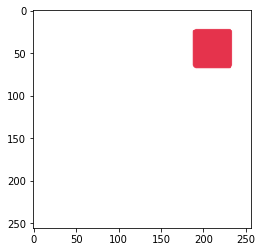

In [282]:
img = soft_render_square(true_square, true_location, init_canvas(device),
                         background_depth=-1e-3, color_sharpness=1e-4, blur=1e-4)
plt.imshow(img.cpu().permute(1, 2, 0))

## Optimize learnable square

In [275]:
import itertools

In [432]:
def get_location(raw_location):
    min_x = -0.8
    max_x = 0.8
    return raw_location.sigmoid() * (max_x - min_x) + min_x


def get_color_sharpness(raw_color_sharpness):
    return raw_color_sharpness.exp()


def get_blur(raw_blur):
    return raw_blur.exp()

In [286]:
def get_loss(raw_location, learnable_square, raw_color_sharpness, raw_blur, true_img):
    num_channels, num_rows, num_cols = img.shape
    loc = soft_render_square(learnable_square, get_location(raw_location), init_canvas(device),
                             color_sharpness=get_color_sharpness(raw_color_sharpness),
                             blur=get_blur(raw_blur))
    return -torch.distributions.Independent(
        torch.distributions.Normal(loc, 1.), reinterpreted_batch_ndims=3
    ).log_prob(true_img)

In [287]:
true_square = Square("A", torch.tensor([0.9, 0.2, 0.3], device=device), torch.tensor(0.3, device=device))
true_location = torch.tensor([0.5, 0.5], device=device)
true_img = render_square(true_square, true_location, init_canvas(device))

In [288]:
def optim_step(optimizer, raw_location, learnable_square, raw_color_sharpness, raw_blur, true_img):
    optimizer.zero_grad()
    loss = get_loss(raw_location, learnable_square, raw_color_sharpness, raw_blur, true_img)
    loss.backward()
    optimizer.step()
    return loss.item()

In [289]:
from tqdm import tqdm

In [290]:
def plot_iter(img, img_hard_render, true_img, losses, img_path):
    fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 1 * 4))
    axs[0].imshow(img.cpu().permute(1, 2, 0).detach().numpy())
    axs[0].set_title("Soft render")
    axs[1].imshow(img_hard_render.cpu().permute(1, 2, 0).detach().numpy())
    axs[1].set_title("Hard render")
    axs[2].imshow(true_img.cpu().permute(1, 2, 0).detach().numpy())
    axs[2].set_title("Target")
    for ax in axs[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])
    axs[3].plot(losses)
    axs[3].set_title("Loss")
    axs[3].set_xlabel("Iteration")
    util.save_fig(fig, img_path)

In [291]:
# Init
learnable_square = LearnableSquare("A").to(device)
raw_color_sharpness = nn.Parameter(torch.randn((), device=device))
raw_blur = nn.Parameter(torch.randn((), device=device))
raw_location = nn.Parameter(torch.randn((2,), device=device))

optimizer = torch.optim.Adam(itertools.chain(
    learnable_square.parameters(),
    [raw_blur, raw_color_sharpness, raw_location]
))

# Optim
num_iterations = 20000
losses = []
img_paths = []
for iteration in tqdm(range(num_iterations)):
    losses.append(
        optim_step(optimizer, raw_location, learnable_square, raw_color_sharpness, raw_blur, true_img)
    )
    if iteration % 1000 == 0:
        img = soft_render_square(learnable_square, get_location(raw_location), init_canvas(device),
                                 color_sharpness=get_color_sharpness(raw_color_sharpness),
                                 blur=get_blur(raw_blur))
        img_hard_render = render_square(learnable_square, get_location(raw_location), init_canvas(device))
        
        # Plot
        img_paths.append(f"tmp/{iteration}.png")
        plot_iter(img, img_hard_render, true_img, losses, img_paths[-1])

  0%|          | 0/20000 [00:00<?, ?it/s]

21:12:09 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/0.png


  5%|▍         | 995/20000 [00:09<02:46, 113.95it/s]

21:12:18 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/1000.png


 10%|▉         | 1999/20000 [00:17<02:24, 124.15it/s]

21:12:27 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/2000.png


 15%|█▍        | 2997/20000 [00:25<02:06, 134.35it/s]

21:12:35 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/3000.png


 20%|█▉        | 3988/20000 [00:32<01:54, 140.13it/s]

21:12:42 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/4000.png


 25%|██▍       | 4988/20000 [00:40<01:47, 139.97it/s]

21:12:50 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/5000.png


 30%|██▉       | 5998/20000 [00:48<01:46, 131.39it/s]

21:12:58 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/6000.png


 35%|███▍      | 6988/20000 [00:57<01:49, 119.19it/s]

21:13:07 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/7000.png


 40%|███▉      | 7992/20000 [01:06<01:43, 115.86it/s]

21:13:16 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/8000.png


 45%|████▍     | 8993/20000 [01:15<01:35, 114.83it/s]

21:13:24 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/9000.png


 50%|████▉     | 9996/20000 [01:24<01:27, 114.23it/s]

21:13:33 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/10000.png


 55%|█████▍    | 10988/20000 [01:32<01:14, 120.65it/s]

21:13:42 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/11000.png


 60%|█████▉    | 11999/20000 [01:41<01:08, 116.99it/s]

21:13:51 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/12000.png


 65%|██████▍   | 12993/20000 [01:50<00:59, 117.03it/s]

21:14:00 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/13000.png


 70%|██████▉   | 13993/20000 [01:59<00:52, 115.16it/s]

21:14:09 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/14000.png


 75%|███████▌  | 15000/20000 [02:08<00:41, 120.73it/s]

21:14:18 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/15000.png


 80%|███████▉  | 15990/20000 [02:16<00:35, 114.54it/s]

21:14:26 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/16000.png


 85%|████████▍ | 16990/20000 [02:25<00:25, 118.14it/s]

21:14:35 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/17000.png


 90%|████████▉ | 17990/20000 [02:34<00:17, 115.94it/s]

21:14:44 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/18000.png


 95%|█████████▍| 18987/20000 [02:42<00:06, 161.98it/s]

21:14:51 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/19000.png


100%|██████████| 20000/20000 [02:48<00:00, 118.44it/s]


In [ ]:
util.make_gif(img_paths, "training.gif", fps=3)

# Simpler true generative model

## Stacking program

In [579]:
def sample_stacking_program(num_primitives, device):
    # Init
    stacking_program = []
    num_sampled_primitives = 0

    # Sample first primitive
    primitive_id_logits = torch.ones((num_primitives,), device=device)
    primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                               pyro.distributions.Categorical(logits=primitive_id_logits))
    num_sampled_primitives += 1
    stacking_program.append(primitive_id)

    # Sample the rest
    end_program = False
    while not end_program:
        # Sample an action for the next primitive
        # Action 0: put to the left of existing stack
        # Action 1: end program
        num_actions = 2
        action_id_logits = torch.ones((num_actions,), device=device)
        action_id = pyro.sample(f"action_id_{num_sampled_primitives}",
                                pyro.distributions.Categorical(logits=action_id_logits))

        if action_id == 1:
            # End program
            end_program = True
            break
        else:
            # Sample primitive
            primitive_id_logits = torch.ones((num_primitives,), device=device)
            primitive_id = pyro.sample(f"primitive_id_{num_sampled_primitives}",
                                       pyro.distributions.Categorical(logits=primitive_id_logits))
            num_sampled_primitives += 1

            # Add to the stacking program based on previous action
            stacking_program.append(primitive_id)

    return stacking_program


def stacking_program_to_str(stacking_program, primitives):
    return [primitives[primitive_id].name for primitive_id in stacking_program]

In [580]:
stacking_program = sample_stacking_program(num_primitives, device)
stacking_program

[tensor(2, device='cuda:0'), tensor(1, device='cuda:0')]

## Raw positions

In [581]:
def sample_raw_locations(stacking_program):
    device = stacking_program[0].device
    dist = pyro.distributions.Normal(torch.tensor(0., device=device), 1)
    raw_locations = []
    for primitive_id, stack in enumerate(stacking_program):
        raw_locations.append(pyro.sample(f"primitive_{primitive_id}_raw_loc",
                                         dist))
    return raw_locations

In [582]:
raw_locations = sample_raw_locations(stacking_program)
raw_locations

[tensor(-1.7956, device='cuda:0'), tensor(-0.3397, device='cuda:0')]

## Render

In [612]:
def convert_raw_locations(raw_locations, stacking_program, primitives):
    # Sample the bottom
    y = torch.tensor(-1., device=device)
    min_x = -0.8
    max_x = 0.8
    locations = []
    for primitive_id, raw_location in zip(stacking_program, raw_locations):
        size = primitives[primitive_id].size
        
        min_x = min_x - size
        x = raw_location.sigmoid() * (max_x - min_x) + min_x
        locations.append(torch.stack([x, y]))
        
        y = y + size
        min_x = x
        max_x = min_x + size
    return locations

In [613]:
locations = convert_raw_locations(raw_locations, stacking_program, primitives)
locations

[tensor([-0.2438, -1.0000], device='cuda:0'),
 tensor([-0.3414, -0.8000], device='cuda:0'),
 tensor([-0.3864, -0.6000], device='cuda:0')]

In [614]:
def render(primitives, stacking_program, raw_locations, num_channels=3, num_rows=256, num_cols=256):
    # Convert
    locations = convert_raw_locations(raw_locations, stacking_program, primitives)

    # Render
    canvas = init_canvas(device, num_channels, num_rows, num_cols)
    for primitive_id, location in zip(stacking_program, locations):
        primitive = primitives[primitive_id]
        canvas = render_square(primitive, location, canvas)

    return canvas

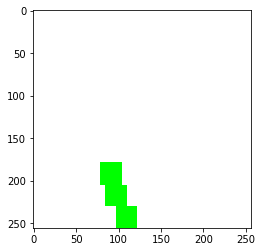

In [615]:
img = render(primitives, stacking_program, raw_locations)
plt.imshow(img.cpu().permute(1, 2, 0))

In [587]:
def soft_render(primitives, stacking_program, raw_locations,
                raw_color_sharpness, raw_blur,
                num_channels=3, num_rows=256, num_cols=256):
    # Convert
    locations = convert_raw_locations(raw_locations, stacking_program, primitives)

    # Render
    canvas = init_canvas(device, num_channels, num_rows, num_cols)
    for primitive_id, location in zip(stacking_program, locations):
        primitive = primitives[primitive_id]
        canvas = soft_render_square(primitive, location, canvas,
                                    color_sharpness=get_color_sharpness(raw_color_sharpness),
                                    blur=get_blur(raw_blur))

    return canvas

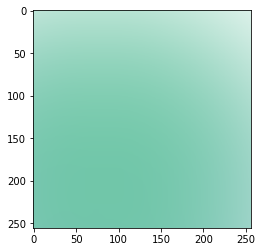

In [588]:
img = soft_render(primitives, stacking_program, raw_locations,
                  torch.randn((), device=device), torch.randn((), device=device))
plt.imshow(img.cpu().permute(1, 2, 0))

## All in one

In [597]:
raw_locations

[tensor(-0.1167, device='cuda:0')]

[tensor(1.0672, device='cuda:0'), tensor(0.0665, device='cuda:0'), tensor(1.5016, device='cuda:0')]


['A', 'C', 'B']

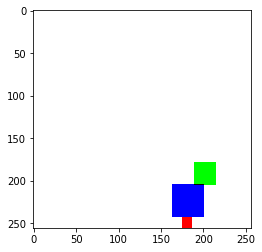

In [656]:
# Define params
primitives = [
    Square("A", torch.tensor([1.0, 0.0, 0.0], device=device), torch.tensor(0.1, device=device)),
    Square("B", torch.tensor([0.0, 1.0, 0.0], device=device), torch.tensor(0.2, device=device)),
    Square("C", torch.tensor([0.0, 0.0, 1.0], device=device), torch.tensor(0.3, device=device))
]
num_primitives = len(primitives)
num_channels, num_rows, num_cols = 3, 256, 256

# Sample
stacking_program = sample_stacking_program(num_primitives, device)
raw_locations = sample_raw_locations(stacking_program)
print(raw_locations)
# Render
img = render(primitives, stacking_program, raw_locations)

# Plot
plt.imshow(img.cpu().permute(1, 2, 0))
stacking_program_to_str(stacking_program, primitives)

In [657]:
true_stacking_program = stacking_program
true_raw_locations = raw_locations
true_img = img

## Optimizing a few learnable squares

In [658]:
def get_loss(raw_locations, learnable_squares, stacking_program, raw_color_sharpness, raw_blur, true_img):
    num_channels, num_rows, num_cols = img.shape
    loc = soft_render(learnable_squares, stacking_program, raw_locations, raw_color_sharpness, raw_blur)
    return -torch.distributions.Independent(
        torch.distributions.Normal(loc, 1.), reinterpreted_batch_ndims=3
    ).log_prob(true_img)

In [663]:
# Init
learnable_squares = [
    LearnableSquare(f"{i}").to(device) for i in range(num_primitives)
]
raw_color_sharpness = nn.Parameter(torch.rand((), device=device))
raw_blur = nn.Parameter(torch.rand((), device=device))
raw_locations = [nn.Parameter(torch.rand((), device=device)) for i in range(len(stacking_program))]

optimizer = torch.optim.Adam(itertools.chain(
    [raw_blur, raw_color_sharpness],
    raw_locations,
    *[learnable_square.parameters() for learnable_square in learnable_squares],
))

# Optim
num_iterations = 50000
losses = []
img_paths = []
for iteration in tqdm(range(num_iterations)):
    optimizer.zero_grad()
    loss = get_loss(raw_locations, learnable_squares, true_stacking_program,
                    raw_color_sharpness, raw_blur, true_img)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if iteration % 1000 == 0:
        print(iteration)
        img = soft_render(learnable_squares, true_stacking_program, raw_locations, raw_color_sharpness, raw_blur)
        img_hard_render = render(learnable_squares, true_stacking_program, raw_locations)
        
        # Plot
        img_paths.append(f"tmp/{iteration}.png")
        plot_iter(img, img_hard_render, true_img, losses, img_paths[-1])
        util.make_gif(img_paths, "training_simple.gif", fps=3)

  0%|          | 0/50000 [00:00<?, ?it/s]

0
18:47:53 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/0.png
18:47:53 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


  2%|▏         | 999/50000 [00:24<19:04, 42.82it/s] 

1000
18:48:17 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/1000.png
18:48:17 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


  4%|▍         | 1999/50000 [00:48<18:04, 44.26it/s]

2000
18:48:41 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/2000.png
18:48:41 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


  6%|▌         | 2998/50000 [01:12<18:04, 43.35it/s]

3000
18:49:05 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/3000.png
18:49:05 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


  8%|▊         | 4000/50000 [01:36<19:20, 39.65it/s]

4000
18:49:29 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/4000.png
18:49:30 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 10%|▉         | 4997/50000 [02:02<18:45, 40.00it/s]

5000
18:49:55 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/5000.png
18:49:56 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 12%|█▏        | 5998/50000 [02:27<17:46, 41.24it/s]  

6000
18:50:20 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/6000.png
18:50:21 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 14%|█▍        | 6997/50000 [02:53<18:13, 39.32it/s]

7000
18:50:46 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/7000.png
18:50:46 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 16%|█▌        | 7999/50000 [03:18<16:51, 41.50it/s]  

8000
18:51:11 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/8000.png
18:51:12 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 18%|█▊        | 8999/50000 [03:44<16:56, 40.34it/s]

9000
18:51:37 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/9000.png
18:51:38 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 20%|█▉        | 9999/50000 [04:09<16:22, 40.72it/s]

10000
18:52:02 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/10000.png
18:52:03 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 22%|██▏       | 10998/50000 [04:35<16:26, 39.55it/s]  

11000
18:52:28 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/11000.png
18:52:29 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 24%|██▍       | 11996/50000 [05:00<15:02, 42.09it/s]  

12000
18:52:54 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/12000.png
18:52:54 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 26%|██▌       | 12999/50000 [05:27<14:45, 41.76it/s]  

13000
18:53:20 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/13000.png
18:53:21 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 28%|██▊       | 13997/50000 [05:53<14:52, 40.34it/s]  

14000
18:53:45 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/14000.png
18:53:47 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 30%|███       | 15000/50000 [06:19<14:02, 41.54it/s]  

15000
18:54:12 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/15000.png
18:54:13 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 32%|███▏      | 15998/50000 [06:45<13:38, 41.52it/s]  

16000
18:54:38 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/16000.png
18:54:39 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 34%|███▍      | 17000/50000 [07:11<14:00, 39.26it/s]  

17000
18:55:04 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/17000.png
18:55:06 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 36%|███▌      | 17996/50000 [07:38<13:14, 40.26it/s]  

18000
18:55:31 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/18000.png
18:55:32 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 38%|███▊      | 18996/50000 [08:04<12:24, 41.65it/s]  

19000
18:55:57 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/19000.png
18:55:59 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 40%|███▉      | 19996/50000 [08:31<12:21, 40.46it/s]  

20000
18:56:24 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/20000.png
18:56:25 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 42%|████▏     | 20996/50000 [08:57<12:02, 40.17it/s]  

21000
18:56:50 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/21000.png
18:56:52 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 44%|████▍     | 21999/50000 [09:24<11:32, 40.45it/s]  

22000
18:57:17 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/22000.png
18:57:19 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 46%|████▌     | 22998/50000 [09:51<11:07, 40.46it/s]  

23000
18:57:44 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/23000.png
18:57:45 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 48%|████▊     | 24000/50000 [10:17<10:32, 41.08it/s]  

24000
18:58:10 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/24000.png
18:58:12 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 50%|████▉     | 24997/50000 [10:44<10:02, 41.48it/s]  

25000
18:58:37 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/25000.png
18:58:39 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 52%|█████▏    | 25998/50000 [11:11<09:20, 42.85it/s]  

26000
18:59:04 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/26000.png
18:59:06 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 54%|█████▍    | 26997/50000 [11:38<09:08, 41.93it/s]  

27000
18:59:31 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/27000.png
18:59:33 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 56%|█████▌    | 27999/50000 [12:05<09:09, 40.07it/s]  

28000
18:59:58 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/28000.png
19:00:01 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 58%|█████▊    | 28998/50000 [12:33<08:51, 39.52it/s]  

29000
19:00:25 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:19 | INFO: Saved to tmp/29000.png
19:00:28 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif


 60%|█████▉    | 29881/50000 [12:57<08:43, 38.44it/s]  


KeyboardInterrupt: 

In [523]:
util.make_gif(img_paths, "training_simple.gif", fps=3)

18:17:11 | /rdma/vast-rdma/vast/tenenbaum/tuananh/git/continuous_mws/stacking/util.py:28 | INFO: Saved to training_simple.gif
